<a href="https://colab.research.google.com/github/manuelcampagnolo/exemplos_python/blob/main/PlantDiseaseDetectionCostanza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 7.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
import rasterio
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from scipy.signal import convolve2d 
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict 

Criar caminho na drive pessoal

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
UTILIZADOR="C" # "MC" ou "C"
#
  #PATH = '/content/drive/MyDrive/Tese/Data/'
  #%cd '/content/drive/MyDrive/Tese/Data' # facultativo
#if UTILIZADOR == "MC":
  #PATH = '/content/drive/MyDrive/investigacao/costanza_mildio_batateira/'
  #%cd '/content/drive/MyDrive/Data_Costanza/'

#if PATH not in sys.path: sys.path.append(PATH_PIPELINE)

# Inputs: tif (nbands) e ficheiro csv pontos amostra revisto (só tem x,y,tipo)

In [ ]:
#Path to image

if UTILIZADOR == "C":
  tif ='/content/drive/MyDrive/Tese/Data/298_3763.tif'
if UTILIZADOR == "MC":
  tif ='/content/drive/MyDrive/inv_proj/costanza_mestrado_2022/298_3763.tif'

#url ='https://drive.google.com/file/d/1-3JEkN3hH3huXEnC9kE7Yqlk6KpsqGIX/view?usp=sharing'

#tif=os.path.join(PATH,'298_3763.tif')

ds = rasterio.open(tif)
ds

data = ds.read()
print(data.shape)
#data_10=data.copy()

(164, 410, 410)


# Functions

## Funções conversão de array 3D em 2D e vice-versa; plot brilho imagem; detrending polinomial

In [ ]:
# input: array3D: nbands, nrows, ncols
# output: array2D: nrows*ncols, bands
def array3dToArray2d(array3d):
  Bands=array3d.shape[0]
  nrows = array3d.shape[1]
  ncols = array3d.shape[2]
  ReshapedMatrix= array3d.transpose().reshape((nrows*ncols, Bands))
  #print(reshaped_array2[:,-10:])
  ReshapedArray = np.array(ReshapedMatrix)
  return ReshapedArray, nrows, ncols

In [ ]:
# input: array3D: nbands, nrows, ncols
# output: array2D: nrows*ncols, bands
def array2dToXY(img):
  nrows = img.shape[0]
  ncols = img.shape[1]
  z= img.transpose().reshape((nrows*ncols, 1))
  #print(reshaped_array2[:,-10:])
  # rows and column indices
  xs=[]
  ys=[]
  for i in np.arange(nrows):
    for j in np.arange(ncols):
      xs.append(i)
      ys.append(j)
  return z.flatten(),np.asarray(xs),np.asarray(ys),nrows,ncols

In [ ]:
# input: vector nrows*ncols
# output array2D: nrows, ncols
def array2dToArray3d(y,nrows,ncols):
  return y.reshape((nrows, ncols), order = 'F')

In [ ]:
def plotImageBrigthness(img,prob):
  q=np.quantile(img,prob)
  img = img.astype(np.float64)
  img[img>q]=np.nan
  plt.imshow(img,cmap='gray')


In [ ]:
def detrendPolyDeg2Array3d(data,prob):
  newdata=data.copy()
  newdata=newdata.astype(np.float64)
  for i in range(data.shape[0]):
    if i%25==0: print(i)
    img=data[i,:,:]
    img = img.astype(np.float64)
    q=np.quantile(img,prob)
    imgq=img.copy() # image with pixels to be converted to nan
    imgq[imgq>q]=np.nan
    zs,xs,ys,nrows,ncols=array2dToXY(imgq)
    xn=xs[~np.isnan(zs)]
    yn=ys[~np.isnan(zs)]
    zn=zs[~np.isnan(zs)]
    # regression
    XY=np.column_stack((xn,yn))
    polyreg=make_pipeline(PolynomialFeatures(2),LinearRegression())
    polyreg.fit(XY,zn)
    aXY=np.column_stack((xs,ys)) # ja usa todos os x,y, mesmo se z é nan
    z=polyreg.predict(aXY)
    imgz=array2dToArray3d(z,nrows,ncols)
    newimg=np.add(np.subtract(img,imgz),np.min(imgz))
    newdata[i,:,:]=newimg
  return newdata

In [ ]:
#Path to functions
#%run '/content/drive/MyDrive/Colab Notebooks/finalcode_functions.py'??

## Funções para criar localizações dos pontos da amostra a partir de data e de df original. A partir de agora já não é preciso e usa-se sempre pontos_amostra_revistos.csv

In [ ]:
def determineXYfromDfAndData(df,data,idxInicioBandas,idxVarResposta):
  x=[]
  y=[]
  tipo=[]
  data2D,nrows,ncols=array3dToArray2d(data)
  # cycle through all cells of data
  for k in range(df.shape[0]):
    print(k)
    t=0 # counter for cells in data
    stop=False
    for i in range(nrows):
      for j in range(ncols): 
        #if i==1 and j==1: 
        #  print(len(data2D[t,]), len(df.iloc[k,idxInicioBandas:]))
        #  print(data2D[t,])
        #  print(df.iloc[k,idxInicioBandas:].to_numpy().astype(int))
        if not stop:
          if all(data2D[t,]==df.iloc[k,idxInicioBandas:].to_numpy().astype(int)):
            x.append(i)
            y.append(j)
            tipo.append(df.iloc[k,idxVarResposta])
            stop=True
            print('posicao na amostra:',k)
            print('row and col ',i,j)
            print(data2D[t,])
        if i==nrows-1 and j==ncols-1 and not stop: print('no match')
        t=t+1
  return x,y,tipo

In [ ]:
url='https://docs.google.com/spreadsheets/d/1Eq28NJ4cfw_Djy3M25gPMbNiH9TG_9DvMqfVLGt0QrQ/edit#gid=919873235'
gc = gspread.authorize(creds)
worksheet = gc.open_by_url(url).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# column names derived from first row of data
colnames=[x.split('SAMPLE_')[-1] for x in rows[0]]
nomeVarResposta=colnames[idxVarResposta]
#print(nomeVarResposta)

# Convert to a DataFrame and render.
df=pd.DataFrame.from_records(rows[1:],columns=colnames)
df


NameError: ignored

In [ ]:
# demora muito tempo: foi só preciso fazer uma vez para criar pontos_amostra_revistos.csv
if True:
  idxInicioBandas=4
  idxVarResposta=1
  xytipo=determineXYfromDfAndData(df,data,idxInicioBandas,idxVarResposta)

NameError: ignored

In [ ]:
if False:
  from pandas.io.formats.style_render import DataFrame
  x=xytipo[0]
  y=xytipo[1]
  tipo=xytipo[2]
  basic_df = pd.DataFrame({'x': x,'y': y, 'tipo':tipo})
  basic_df.to_csv('/content/drive/MyDrive/Tese/Data/pontos_amostra_revistos.csv')

In [ ]:
# def extractXYfromData(df,data):
#   # new names for columns
#   colnames=df.columns[range(idxInicioBandas,len(df.columns))].to_list()
#   newcolumns=[df.columns[idxVarResposta],df.columns[idxPosicaoX],df.columns[idxPosicaoY]]+[str(348+int(x)*4) for x in colnames]
#   #
#   newdf=pd.DataFrame(columns=newcolumns)
#   # compute new df
#   for i in range(df.shape[0]):
#     tipo=df.iloc[i,idxVarResposta]
#     x=df.iloc[i,idxPosicaoX]
#     y=df.iloc[i,idxPosicaoY]
#     #print(x,y)
#     bands=[]
#     for j in range(data.shape[0]): #bands
#       bands.append(data[j,int(x),int(y)])
#     newdf.loc[len(newdf.index)] = [tipo]+[x,y]+bands 
#   return newdf

    

In [ ]:
# #df: matrix of rows n*(p+2) and columns y=bands

# def df_(df, Bands): 
#   firstCols=['fid','Tipo','x','y']
#   #newBands=[str(350+2+x*4) for x in range(0,160)]
#   firstCols[4:]= Bands

#   df.columns=firstCols
#   df = df.iloc[1: , :] # porque é que se está a eliminar a 1a linha de df?
#   df['Tipo']=df['Tipo'].str.lower() # all Tipos in lower case
  
#   return df

In [ ]:
#newBands=[str(350+2+x*4) for x in range(0,164)]
#print(df_10)
#print(df_(df_10,newBands))

## Função para adicionar valores das bandas à dataframe dos pontos_amostra (que só tem colunas x, y e tipo)

In [ ]:
# df has only 3 relevant columns: x, y, tipo
# add to df band values from data
def extractBandsFromDataAndXY(df,data,nomeVarResposta,nomeX,nomeY,listaNomesBandas):
  colnames=df.columns.to_list()
  k=colnames.index(nomeVarResposta)
  i=colnames.index(nomeX)
  j=colnames.index(nomeY)
  # print(idxPosicaoX,idxPosicaoY,idxVarResposta)
  nbandas=data.shape[0]
  # names for extended df (with bands)
  newcolumns=[df.columns[k],df.columns[i],df.columns[j]]+listaNomesBandas # [str(352+int(x)*4) for x in range(nbandas)]
  newdf=pd.DataFrame(columns=newcolumns)
  # novas posições em newdf:
  idxVarResposta=0
  idxPosicaoX=1
  idxPosicaoY=2
  idxInicioBandas=3
  # compute new df
  for t in range(df.shape[0]):
    tipo=df.iloc[t,k]
    x=df.iloc[t,i]
    y=df.iloc[t,j]
    #print(x,y)
    bands=[]
    for band in range(data.shape[0]): #bands
      bands.append(data[band,int(x),int(y)]) 
    newdf.loc[len(newdf.index)] = [tipo]+[x,y]+bands 
  return newdf,idxVarResposta,idxPosicaoX,idxPosicaoY,idxInicioBandas


## LDA, RF, CV

Discriminant analysis and conversion from class names to class indices

In [ ]:
# df is  the sample matrix (94,167) 
# nomeVarResposta is 'Tipo'
# idxInicioBandas is 4, since hyoperspectral bands satrt at index 4 in df
# lda: linear combination of features that characterizes or separates the classes
# X_lda: matrix n*k, with k= (n° of classes - 1); each column is the component on the k-th discriminate axis
# target_names are the class names (from df.Tipo)
# target_values are the class indices [0,1,...6]
# y are the class indices of the response variable 

def comp_discrim(df,nomeVarResposta, idxInicioBandas):
  #df = df.iloc[1: , :]
  X = np.array(df.iloc[:,idxInicioBandas:])
  le = LabelEncoder()
  y = le.fit_transform(df[nomeVarResposta])
  #print(y)
  target_names=le.inverse_transform([x for x in range(min(y),max(y)+1)])
  target_values=[x for x in range(min(y),max(y)+1)]
  #print(target_names)
  #print(target_values)
  #print(np.bincount(y)) # np.bincount(x)
  lda = LinearDiscriminantAnalysis() # (n_components=1)
  lda.fit(X,y)
  X_lda = lda.transform(X)
  return X_lda, y, target_names,target_values, lda, X

Random forests for classification; returns classifier

In [ ]:
# X: matrix containing the features of the input data
# y: label vector of the input data
# max_depth: maximum depth of the tree
def classRF(X, y, md,bootstrap,cv):
  #df = df.iloc[1: , :]
  #le = LabelEncoder()
  #y = le.fit_transform(df['Tipo'])
  #X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=ts, random_state=0)
  
  classifier = RandomForestClassifier(max_depth= md, random_state=0,bootstrap=bootstrap)
  #classifier.fit(X_train, y_train)
  classifier.fit(X, y)
  #y_pred = classifier.predict(X)
  y_pred= cross_val_predict(classifier, X, y, cv=cv)
  return y_pred, classifier 

Convert image to 2d-array, apply lda, apply classifier to classify all pixels, reshape to image format (1 band) 

In [ ]:
# transform data with LDA; then, train RF classifier with df and apply it to array3d
def ldaRfClassifyImage(array3d, df,idxInicioBandas,nomeVarResposta,md,bootstrap,CW):
  # reshape input image
  A,nrows,ncols=array3dToArray2d(array3d) # está a ler por colunas da imagem
  # training data from df
  X = np.array(df.iloc[:,idxInicioBandas:])
  print(X.shape)
  le = LabelEncoder()
  y = le.fit_transform(df[nomeVarResposta])
  # LDA
  lda = LinearDiscriminantAnalysis() # (n_components=1)
  lda.fit(X,y)
  X_lda = lda.transform(X) # transform training sample
  print(X_lda.shape)
  A_lda = lda.transform(A) # transform image
  # RF
  classifier = RandomForestClassifier(max_depth= md, random_state=0,bootstrap=bootstrap,class_weight=CW)  # e.g. CW={0:10,1:1,2:1/2,3:1/10,4:1/5,5:1/2}
  #classifier.fit(X_train, y_train)
  classifier.fit(X_lda, y) # train with lda transformed sample
  y_pred = classifier.predict(A_lda) # apply to lda transform image
  return array2dToArray3d(y_pred,nrows,ncols)

Com LDA, sem RF

In [ ]:
# transform data and classify with LDA
def ldaClassifyImage(array3d, df,idxInicioBandas,nomeVarResposta):
  # reshape input image
  A,nrows,ncols=array3dToArray2d(array3d) # está a ler por colunas da imagem
  # training data from df
  X = np.array(df.iloc[:,idxInicioBandas:])
  print(X.shape)
  le = LabelEncoder()
  y = le.fit_transform(df[nomeVarResposta])
  # LDA
  lda = LinearDiscriminantAnalysis() # (n_components=1)
  lda.fit(X,y)
  y_pred = lda.predict(A)
  return array2dToArray3d(y_pred,nrows,ncols)

Alternativa: não usar LDA e fazer a classificação directamente usando as 164 bandas como features

In [ ]:
# train RF classifier with df and apply it to array3d
def classifyImage(array3d, mydf,idxInicioBandas,nomeVarResposta,md,bootstrap,CW):
  df=mydf.copy()
  # reshape input image
  A,nrows,ncols=array3dToArray2d(array3d) # está a ler por colunas da imagem
  # training data from df
  X = np.array(df.iloc[:,idxInicioBandas:])
  le = LabelEncoder()
  y = le.fit_transform(df[nomeVarResposta])
  # RF
  classifier = RandomForestClassifier(max_depth= md, random_state=0,bootstrap=bootstrap,class_weight=CW) 
  #classifier.fit(X_train, y_train)
  classifier.fit(X, y) # train with lda transformed sample
  y_pred = classifier.predict(A) # apply to all image
  return array2dToArray3d(y_pred,nrows,ncols)

Cross validation using classifier

In [ ]:
#CrossValidation to evaluate the classifier performance, cv = 5 times computing the score 

def CrossVal(classifier, X,y,cv):
  #df = df.iloc[1: , :]
  #le = LabelEncoder()
  #y = le.fit_transform(df['Tipo'])
  scores = cross_val_score(classifier, X, y, cv=cv)
  print("AUC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  return scores

Converter X,y em uma dataframe

In [ ]:
def convertXtoDf(X_lda,df):
  X=X_lda.copy()
  df_lda=df.copy()
  df_lda=df_lda.iloc[:,:idxInicioBandas]
  #print(df_lda)
  df_lda.reset_index(drop=False, inplace=True)
  pd.DataFrame(data = X)
  df_lda=pd.concat([df_lda, pd.DataFrame(data = X)], axis = 1) #,ignore_index=True)
  #print(df_lda)
  nomesCols=df_lda.columns.to_list()[:-X.shape[1]]+[str(i+1) for i in range(X.shape[1])]
  df_lda.columns=nomesCols
  if 'index' in df_lda.columns:
    df_lda.drop('index', inplace=True, axis=1)
  return df_lda

## Gráficos

Scatter plot to visualize sample observations on the principal discriminant plane

In [ ]:
def ScatterPlot(X_lda, y, nomesClasses, indicesClasses, coresClasses,axis1,axis2): #y
  #df = df.iloc[1: , :]
  #le = LabelEncoder()
  #y = le.fit_transform(df['Tipo'])
  #target_names=le.inverse_transform([x for x in range(min(y),max(y)+1)])
  #target_values=[x for x in range(min(y),max(y)+1)]
  plt.figure()
  for color, i, target_name in zip(coresClasses, indicesClasses, nomesClasses):
      plt.scatter(
          X_lda[y == i, axis1], X_lda[y == i, axis2], alpha=0.8, color=color, label=target_name
      )
  plt.legend(loc="best", shadow=False, scatterpoints=1)
  plt.title("LDA")
  plt.show()

In [ ]:
def Chart(img_array, coresClasses,nomesClasses,indicesClasses,alpha):
  ## first you need to define your color map and value name as a dict
  from matplotlib import colors  
  cmap=dict()
  labels=dict()
  for color, idx, nome in zip(coresClasses, indicesClasses, nomesClasses):
    (r,g,b,a)=colors.to_rgba(color)
    cmap[idx]= [r,g,b,alpha]
    labels[idx]= nome
  #['doente' 'estrada' 'infest' 'rega' 'sao' 'solo' 'sombra'] 4 1 
  # [0, 1, 2, 3, 4, 5, 6]
  #cmap = {0:[1.0,0.1,0.1,t],1:[0.1,0.1,1.0,t],2:[1.0,0.5,0.1,t], 3:[0.5,1.0,0.1,t], 4:[0.1,0.1,0.1,t], 5:[0.1,0.1,0.5,t]}
  #labels = {0:'doente',1:'estrada',2:'infest',3:'sao',4:'solo',5:'sombra'}
  arrayShow = np.array([[cmap[i] for i in j] for j in img_array])   
  ## create patches as legend
  patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]
  plt.imshow(arrayShow)
  #plt.imshow(ReshapedImage)
  plt.legend(handles=patches, loc=7, borderaxespad=0.)
  plt.show()
  return 

In [ ]:
# Output: spectral signature for each  class 
# graphic of the mean spectral signature and standard deviation 

def SpectralSignature(mydf, idxInicioBandas,nomeVarResposta, nomesClasses,coresClasses,Title):
  df=mydf.copy() # to avoid indexing mydf
  df.set_index(nomeVarResposta, inplace=True)
  for nomeClasse in nomesClasses: 
    mycolor=coresClasses[list(nomesClasses).index(nomeClasse)]
    classedf=df.loc[nomeClasse]
    X = np.array(classedf.iloc[:,(idxInicioBandas-1):])
    #if nomeClasse=='doente' : print(X)
    means=X.mean(axis=0)
    stds=X.std(axis=0)
    bandNumbers=df.columns.to_list()[(idxInicioBandas-1):]
    #if nomeClasse=='doente' :  print(bandNumbers)
    bandas=np.asarray([float(i) for i in bandNumbers])
    plt.plot(bandas, means, label= nomeClasse,color=mycolor)
    plt.fill_between(bandas, means-stds,means+stds, alpha=0.1,color=mycolor)
      
  if Title=='Spectral signatures': 
    plt.xlabel('Wavelenght (nm)')
    plt.ylabel('Reflectance (\u2031)')
  plt.legend()
  plt.title(Title)

## Degradação imagens: convolução, etc

In [ ]:
def degradeSpatialResolution(data,mydf,nomeVarResposta,nomeX,nomeY):
  df=mydf.copy()
  kernel = np.array([[0.25,0.25],[0.25,0.25]])
  # determine convoluted image size
  aux1=convolve2d(data[0,:,:], kernel)
  # create convolution array
  C = np.zeros((data.shape[0],aux1.shape[0],aux1.shape[1])) 
  # compute convolution for all bands
  for i in range(data.shape[0]):                                                                                                                                                          
    C[i,:,:] = convolve2d(data[i,:,:], kernel)

  # extract sample from degraded image
  listaNomesBandas=[str(352+int(x)*4) for x in range(data.shape[0])]
  newdf,idxVarResposta,idxPosicaoX,idxPosicaoY,idxInicioBandas=extractBandsFromDataAndXY(df,C,nomeVarResposta,nomeX,nomeY,listaNomesBandas)

  # determine rows and columns to be removed (chessboard)
  rows = [i for i in range(C.shape[1]) if i%2==0]
  cols = [i for i in range(C.shape[2]) if i%2==0]

  # determine output size and define degradedData
  aux2=C[0,:,:][np.ix_(rows,cols)]
  degradedData=np.zeros((data.shape[0],aux2.shape[0],aux2.shape[1]))
  # remove rows and cols
  for i in range(data.shape[0]):  
    degradedData[i,:,:] =C[i,:,:][np.ix_(rows,cols)]
  return degradedData,newdf

In [ ]:
def degradeSpectralResolution(data,BandsMulti,Unc):
  mydata=np.zeros((len(BandsMulti),data.shape[1],data.shape[2]))
  bandas=[int(x) for x in df_10.columns.to_list()[idxInicioBandas:]]
  #print(bandas)
  # A is a (410*410,164) array
  A,nrows,ncols=array3dToArray2d(data)
  # cycle through bands in BandsMulti
  for k in range(len(BandsMulti)):
    first=BandsMulti[k]-Unc[k]
    last=BandsMulti[k]+Unc[k]
    # hyperspectral bands that fall between first and last
    mybands=[banda for banda in bandas if banda > first and banda < last] # adaptar se necessário
    myindices=[bandas.index(myband) for myband in mybands]
    Am=A[:,myindices]
    # average hyperspectral bands
    v=Am.mean(axis=1)
    # reshape as image
    img=array2dToArray3d(v,nrows,ncols)
    mydata[k,:,:]=img
  return mydata

## Outros

In [ ]:
#Calculate Uncertainties 2darray
def BandUncertainties_i(FullData,BandList,Band,Unc):

  first = Band-Unc
  last = Band+Unc

  FirstMatrix = np.zeros([int(FullData.shape[0])])
  LastMatrix=np.zeros([int(FullData.shape[0])])
  Result=np.zeros([int(FullData.shape[0])])

  BandList_int = [int(i) for i in BandList]
  BLA=np.asarray(BandList_int)

  NearestF=(np.abs(BLA-first)).argmin()
  NearestL=(np.abs(BLA-last)).argmin()
  
  if BandList_int[NearestF]>first:
    for i in range(int(FullData.shape[0])):
      #for j in range(int(len(FullData[1]))):
      FirstMatrix[i]=(FullData[i, NearestF]+FullData[i,NearestF-1])/2
      idx_first=NearestF
  elif BandList_int[NearestF]<first:
    for i in range(int(FullData.shape[0])):
      #for j in range(int(len(FullData[1]))):
      FirstMatrix[i]=(FullData[i, NearestF]+FullData[i,NearestF+1])/2
      idx_first=NearestF+1
  else:
    FirstMatrix=FullData[:,NearestF]
    idx_first = NearestF+1

  if BandList_int[NearestL]>last:
    for i in range(int(FullData.shape[0])):
      #for j in range(int(len(FullData[1]))):
      LastMatrix[i]=(FullData[i,NearestL]+FullData[i,NearestL-1])/2
      idx_last=NearestL-1
  elif BandList_int[NearestL]<last:
    for i in range(int(FullData.shape[0])):
      #for j in range(int(len(FullData[1]))):
      LastMatrix[i]=(FullData[i,NearestL]+FullData[i,NearestL+1])/2
      idx_last=NearestL
  else:
    LastMatrix=FullData[:,NearestL]
    idx_last = NearestL+1


  NMatr=idx_last-idx_first

  for i in range(int(FullData.shape[0])):
    #for j in range(int(len(FullData[1]))):
    Result[i]=np.array(((np.sum(FullData[i, idx_first:idx_last]))+FirstMatrix[i]+LastMatrix[i])/(NMatr+2))
  return Result

In [ ]:
def cm1(classifier, X_test, y_test):
  #color = 'white'
  matrix = plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues)
  #matrix.ax_.set_title('Confusion Matrix', color=color)
  #plt.xlabel('Predicted Label', color=color)
  #plt.ylabel('True Label', color=color)
  #plt.gcf().axes[0].tick_params(colors=color)
  #plt.gcf().axes[1].tick_params(colors=color)
  plt.show()

# Préprocessamento

## Preprocessar tif hyperespectral para retirar tendência espacial quadrática em cada banda

Brilho da imagem original (soma dos valores das bandas)

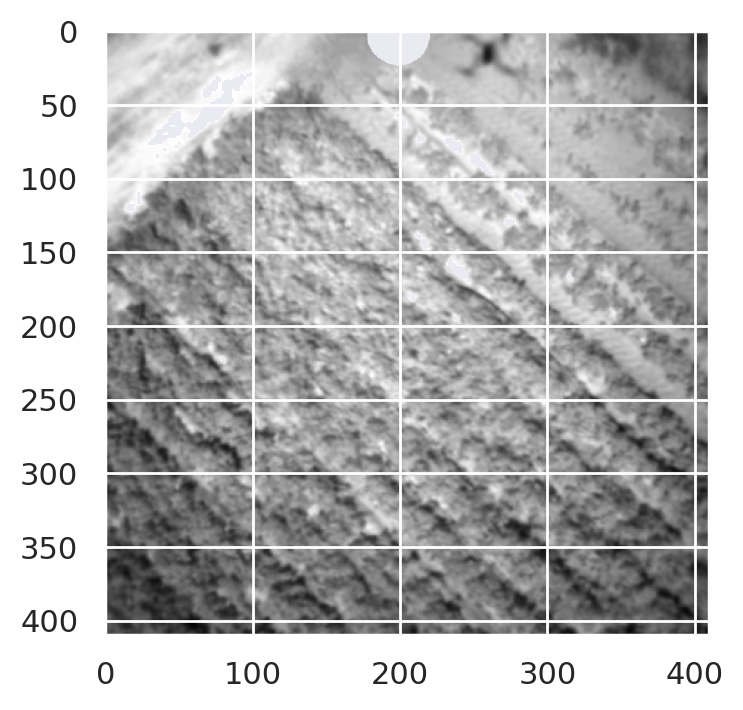

In [ ]:
# remove very bright values (5%)
plt.rcParams['figure.dpi'] = 200
img=data.sum(axis=0)
plotImageBrigthness(img,0.99)

Criar dados para regressão polinomial (x,y,z). Usar regressão polinomial (degree=2) para remover a tendência nos dados, usando y como a soma dos sinais de todas as bandas no ponto (exceto os 5% mais brilhantes)

In [ ]:
newdata=detrendPolyDeg2Array3d(data,0.95) # demora um pouco: tem que ajustar 164 polinómios aos dados

0
25
50
75
100
125
150


In [ ]:
newdata.shape

(164, 410, 410)

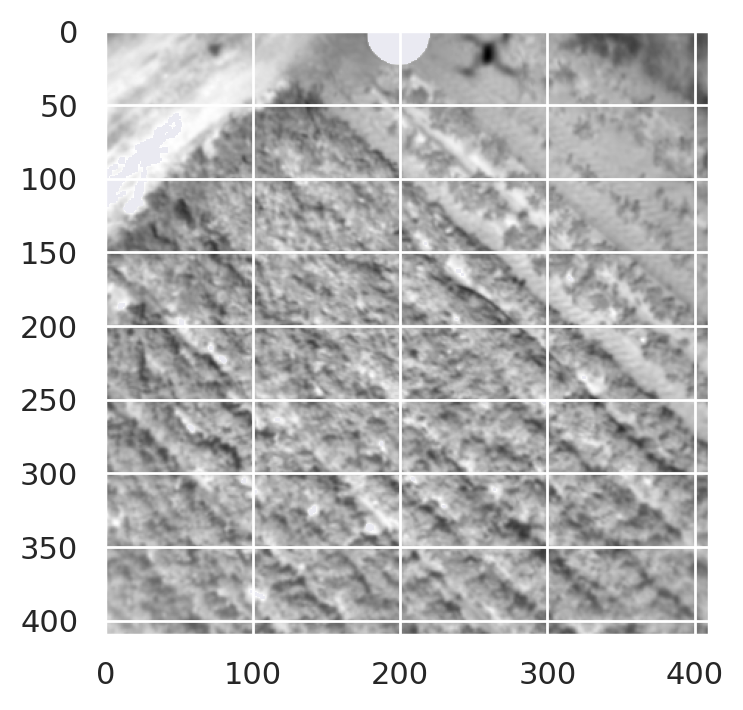

In [ ]:
# remove very bright values (5%)
plt.rcParams['figure.dpi'] = 200
img=newdata.sum(axis=0)
plotImageBrigthness(img,0.99)

Criar data_10

In [ ]:
data_10=newdata.copy() # préprocessamnto: detrending
data_10=data.copy() # sem detrending
data_10=data_10.astype(np.float64)

## Ler pontos_amostra e determinar df_10  ADAPTAR PATH

In [ ]:
# #Path to observations

# #fn='/content/drive/MyDrive/Tese/Data/pontos_amostra_costanza.gsheet'
# url='https://docs.google.com/spreadsheets/d/1Eq28NJ4cfw_Djy3M25gPMbNiH9TG_9DvMqfVLGt0QrQ/edit#gid=919873235'

# # colunas espciais da tabela
# idxFid=0
# idxVarResposta=1
# idxPosicaoX=2
# idxPosicaoY=3
# idxInicioBandas=4 # a partir desta coluna inclusivé, são os valores das bandas espectrais

# #fn=os.path.join(PATH,'pontos_amostra_costanza.gsheet')

# gc = gspread.authorize(creds)
# worksheet = gc.open_by_url(url).sheet1

# # get_all_values gives a list of rows.
# rows = worksheet.get_all_values()

# # column names derived from first row of data
# colnames=[x.split('SAMPLE_')[-1] for x in rows[0]]
# nomeVarResposta=colnames[idxVarResposta]
# #print(nomeVarResposta)

# # Convert to a DataFrame and render.
# df=pd.DataFrame.from_records(rows[1:],columns=colnames)
# # convert classes to lowercase (Sao->sao)
# df[nomeVarResposta]=[x.lower() for x in df[nomeVarResposta]]
# #print(df)

# read /content/drive/MyDrive/inv_proj/costanza_mestrado_2022/pontos_amostra_revistos.csv
df=pd.read_csv('/content/drive/MyDrive/Tese/Data/pontos_amostra_revistos.csv') #<-------------  adaptar path
nomeVarResposta='tipo'
nomeX='y'
nomeY='x'
coresClasses=['red','black','yellow','green','gray','blue'] # ['doente' 'estrada' 'infest' 'sao' 'solo' 'sombra'] [0, 1, 2, 3, 4, 5] le.encoder codifica por ordem alfabética
listaNomesBandas=[str(352+int(x)*4) for x in range(data_10.shape[0])]
df_10,idxVarResposta,idxPosicaoX,idxPosicaoY,idxInicioBandas=extractBandsFromDataAndXY(df,data_10,nomeVarResposta,nomeX,nomeY,listaNomesBandas)
del df
df_10

,tipo,y,x,352,356,360,364,368,372,376,...,968,972,976,980,984,988,992,996,1000,1004
0,Soil,103,218,1.0,1.0,1.0,2.0,3.0,10.0,25.0,...,105.0,105.0,104.0,104.0,104.0,104.0,107.0,111.0,113.0,113.0
1,Soil,79,238,0.0,0.0,0.0,4.0,8.0,27.0,56.0,...,101.0,108.0,116.0,116.0,114.0,113.0,114.0,114.0,114.0,114.0
2,Soil,71,279,0.0,0.0,0.0,2.0,4.0,28.0,58.0,...,93.0,102.0,108.0,103.0,98.0,98.0,99.0,99.0,99.0,99.0
3,Soil,161,238,0.0,0.0,0.0,2.0,5.0,11.0,42.0,...,124.0,123.0,120.0,117.0,117.0,121.0,125.0,128.0,130.0,131.0
4,Soil,113,323,0.0,0.0,1.0,3.0,5.0,11.0,18.0,...,93.0,100.0,104.0,100.0,96.0,100.0,103.0,105.0,105.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,Healthy,224,114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,107.0,108.0,110.0,112.0,112.0,113.0,112.0,111.0,110.0,110.0
90,Healthy,336,214,0.0,0.0,0.0,0.0,0.0,1.0,3.0,...,116.0,121.0,126.0,125.0,123.0,121.0,119.0,117.0,117.0,117.0
91,Healthy,388,126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65.0,68.0,69.0,69.0,67.0,64.0,64.0,64.0,64.0,64.0
92,Diseased,111,290,0.0,0.0,0.0,0.0,1.0,5.0,13.0,...,112.0,115.0,118.0,120.0,121.0,122.0,125.0,128.0,128.0,128.0


In [ ]:
#df_10.loc[df_10.tipo=='doente']

# Processing

## Reference 10 m hyperspectral image


Aplicar função discriminante linear (LDA) e obter objeto lda (hyper, i.e. dados originais 10 m e hyperespectrais)

Input: df_10 (hyper, 10 cm) ; Output: eixos discriminantes; variável resposta (inteiro)

In [ ]:
print(nomeVarResposta)
X_lda, y, nomesClasses, indicesClasses, lda, X = comp_discrim(df_10,nomeVarResposta, idxInicioBandas)
print(nomesClasses,indicesClasses)

tipo
['Diseased' 'Healthy' 'Road' 'Shadow' 'Soil' 'Weeds'] [0, 1, 2, 3, 4, 5]


Visualizar assinaturas espectrais das classes

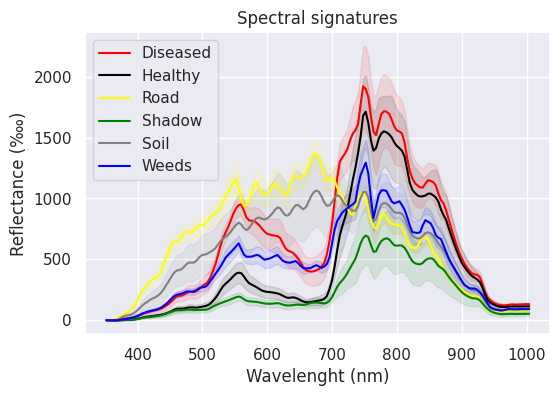

In [ ]:
plt.rcParams['figure.dpi'] = 100
SpectralSignature(df_10, idxInicioBandas,nomeVarResposta, nomesClasses,coresClasses,'Spectral signatures')

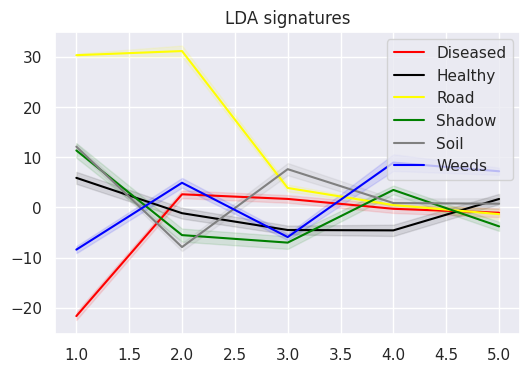

In [ ]:
plt.rcParams['figure.dpi'] = 100
df_lda=convertXtoDf(X_lda,df_10)
SpectralSignature(df_lda, idxInicioBandas,nomeVarResposta, nomesClasses,coresClasses,'LDA signatures')

Visualizar amostra no plano discriminante principal

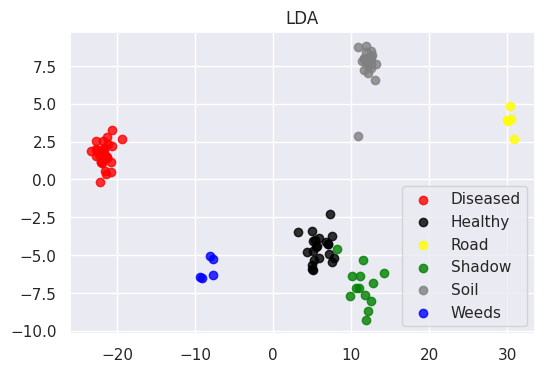

In [ ]:
plt.rcParams['figure.dpi'] = 100
ScatterPlot(X_lda, y, nomesClasses, indicesClasses, coresClasses,0,2)

Aplicar random forest no espaço das funções discrriminantes

In [ ]:
# arg 3 is the depth; arg 4 is bootstrap
y_pred,classifier = classRF(X_lda, y, 3,True,5)
print(classifier)

RandomForestClassifier(max_depth=3, random_state=0)


Fazer cross validation para testar a qualidade da classificação e construir matriz de erro aparente (100% das observações) 

In [ ]:
#print(X_lda_hyper,y)
# po último argumento é cv
scores = CrossVal(classifier, X_lda,y,cv=5)
scores

AUC: 0.99 (+/- 0.04)


array([1.    , 1.    , 0.9474, 1.    , 1.    ])

In [ ]:
cv=5
y_pred,classifier = classRF(X_lda, y, 3,True,cv=5)
print(confusion_matrix(y, y_pred))

[[29  0  0  0  0  0]
 [ 0 22  0  0  0  0]
 [ 0  0  5  0  0  0]
 [ 0  0  0 12  1  0]
 [ 0  0  0  0 20  0]
 [ 0  0  0  0  0  5]]


Input: data_10 (10 cm). Aplicar lda e classificador a toda a imagem original (hyper, 10 cm) e visualizar o resultado

In [ ]:
data_10.shape

(164, 410, 410)

In [ ]:
CW={0:1,1:1,2:1,3:1,4:1,5:1}
#CW={0:100,1:1,2:1,3:1,4:1,5:1}
depthRF=3
bootstrap=True
#img_classif=classifyImage(data_10, df_10,idxInicioBandas,nomeVarResposta,depthRF,bootstrap,CW) # só RF
#img_classif=ldaClassifyImage(data_10, df_10,idxInicioBandas,nomeVarResposta) # só LDA
img_classif=ldaRfClassifyImage(data_10, df_10,idxInicioBandas,nomeVarResposta,depthRF,bootstrap,CW)
img_classif.shape
unique, counts = np.unique(img_classif, return_counts=True)
print(unique, counts)


(94, 164)
(94, 5)
[0 1 2 3 4 5] [ 7367 85370  8104 14762 33779 18718]


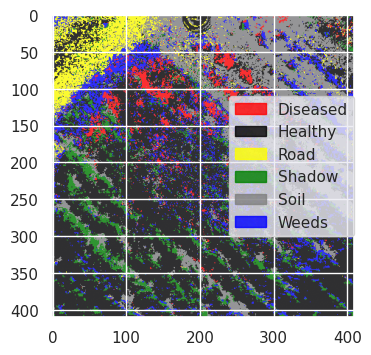

In [ ]:
plt.rcParams['figure.dpi'] = 100
Chart(img_classif, coresClasses,nomesClasses,indicesClasses,0.8)

## Degrade hyperspectral image to 20 cm


Criar Dataframe df_sufixo

In [ ]:
data_20,df_20=degradeSpatialResolution(data_10,df_10,nomeVarResposta,nomeX,nomeY)
data_20.shape
df_20

,tipo,y,x,352,356,360,364,368,372,376,...,968,972,976,980,984,988,992,996,1000,1004
0,Soil,103,218,0.75,0.75,0.75,2.25,4.00,10.50,24.50,...,98.50,100.75,102.75,104.75,104.25,104.25,106.00,108.50,109.75,109.75
1,Soil,79,238,0.00,0.00,0.00,4.00,8.00,26.50,55.50,...,99.50,105.75,112.75,113.50,112.25,112.00,113.50,114.75,114.75,114.75
2,Soil,71,279,0.00,0.00,0.00,2.00,3.75,28.50,59.75,...,90.50,97.00,101.50,99.75,98.00,97.75,97.50,97.50,97.50,97.50
3,Soil,161,238,0.00,0.00,0.00,2.25,5.50,12.00,43.75,...,121.25,120.00,118.75,117.50,117.25,118.25,119.25,121.25,123.25,123.75
4,Soil,113,323,0.00,0.00,0.50,2.50,4.50,11.00,18.50,...,93.50,99.00,102.25,101.00,99.50,101.25,103.00,103.75,103.75,103.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,Healthy,224,114,0.00,0.00,0.00,0.00,0.00,0.00,0.50,...,108.25,108.50,109.50,110.75,111.00,112.00,111.25,110.50,109.50,109.50
90,Healthy,336,214,0.00,0.00,0.00,0.00,0.00,0.25,1.00,...,109.75,114.00,117.75,119.00,120.00,119.25,117.50,115.75,115.75,115.75
91,Healthy,388,126,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,63.00,65.25,65.50,66.00,65.75,65.25,65.25,65.25,65.25,65.25
92,Diseased,111,290,0.00,0.00,0.00,0.75,1.75,6.00,12.75,...,119.00,122.50,126.00,126.75,126.25,126.25,127.50,128.50,128.50,128.50


Aplicar função discriminante linear (LDA) e obter objeto X_lda (hyper, 20 cm)

In [ ]:
print(nomeVarResposta)
X_lda, y, nomesClasses, indicesClasses, lda, X = comp_discrim(df_20,nomeVarResposta, idxInicioBandas)
print(nomesClasses,indicesClasses)

tipo
['Diseased' 'Healthy' 'Road' 'Shadow' 'Soil' 'Weeds'] [0, 1, 2, 3, 4, 5]


Visualizar assinaturas espectrais das classes

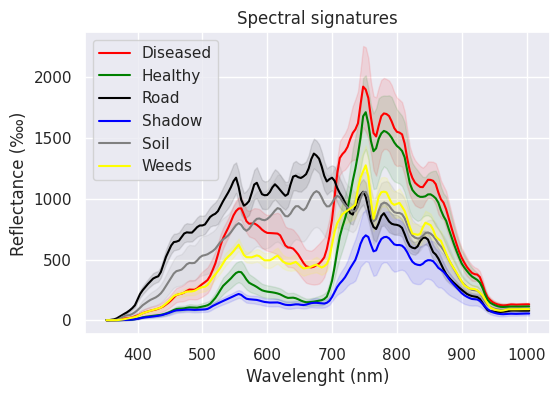

In [ ]:
plt.rcParams['figure.dpi'] = 100
SpectralSignature(df_20, idxInicioBandas,nomeVarResposta, nomesClasses,['red','green','black','blue','grey','yellow'],'Spectral signatures')

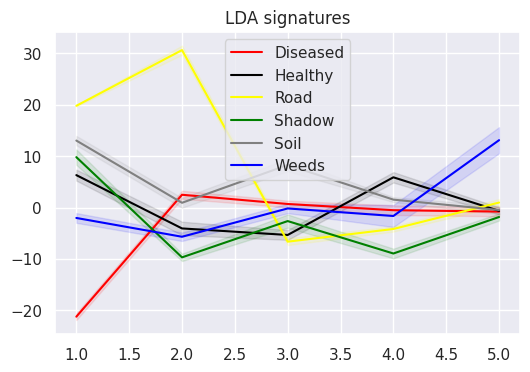

In [ ]:
plt.rcParams['figure.dpi'] = 100
df_lda=convertXtoDf(X_lda,df_20)
SpectralSignature(df_lda, idxInicioBandas,nomeVarResposta, nomesClasses,coresClasses,'LDA signatures')

Visualizar amostra no plano discriminante principal

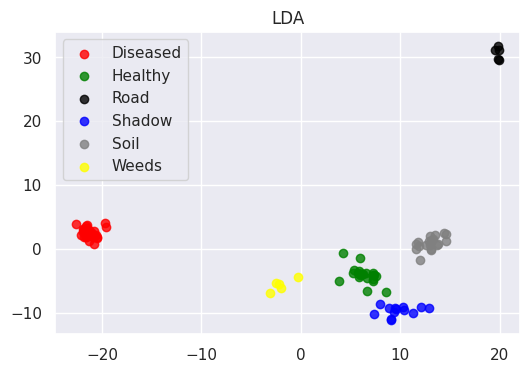

In [ ]:
plt.rcParams['figure.dpi'] = 100
ScatterPlot(X_lda, y, nomesClasses, indicesClasses, coresClasses,0,1)

Aplicar random forest no espaço das funções discrriminantes

In [ ]:
# arg 3 is the depth; arg 4 is bootstrap
y_pred,classifier = classRF(X_lda, y, 3,True, 5)
print(classifier)

RandomForestClassifier(max_depth=3, random_state=0)


Fazer cross validation para testar a qualidade da classificação e construir matriz de erro aparente (100% das observações) 

In [ ]:
#print(X_lda_hyper,y)

scores = CrossVal(classifier, X_lda,y,5)
scores

AUC: 1.00 (+/- 0.00)


array([1., 1., 1., 1., 1.])

In [ ]:
print(nomesClasses)
print(confusion_matrix(y, y_pred))


['Diseased' 'Healthy' 'Road' 'Shadow' 'Soil' 'Weeds']
[[29  0  0  0  0  0]
 [ 0 22  0  0  0  0]
 [ 0  0  5  0  0  0]
 [ 0  0  0 13  0  0]
 [ 0  0  0  0 20  0]
 [ 0  0  0  0  0  5]]


Input: data_20 (20 cm). Aplicar lda e classificador a toda a imagem original (hyper, 20 cm) e visualizar o resultado

In [ ]:
data_20.shape

(164, 206, 206)

In [ ]:
CW={0:1,1:1,2:1,3:1,4:1,5:1}
depthRF=3
bootstrap=True
img_classif=ldaRfClassifyImage(data_20, df_20,idxInicioBandas,nomeVarResposta,depthRF,bootstrap,CW)
img_classif.shape
unique, counts = np.unique(img_classif, return_counts=True)
print(unique, counts)


(94, 164)
(94, 5)
[0 1 2 3 4 5] [ 2919 18034  2439  6173 10306  2565]


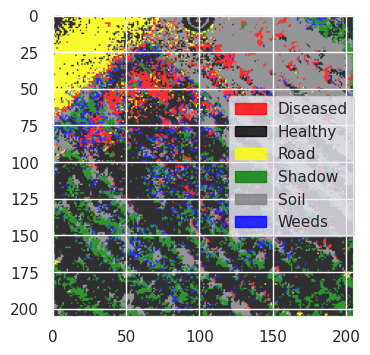

In [ ]:
plt.rcParams['figure.dpi'] = 100
Chart(img_classif, coresClasses,nomesClasses,indicesClasses,0.8)

## Degrade hyperspectral to Phantom-Multispectral image

Each phantom band is $[B-unc,B+unc]$

In [ ]:
BandsMulti = [450, 560, 650, 730, 840]
Unc=[16,16,16,26,16]

Degrade data_10 to Phantom bands to obtain data_ph (410,410)

In [ ]:
data_ph=degradeSpectralResolution(data_10,BandsMulti,Unc)
data_ph.shape

(5, 410, 410)

Extract df_ph from data_ph and df_10

In [ ]:
listaNomesBandas=[str(x) for x in BandsMulti]
df_ph,idxVarResposta,idxPosicaoX,idxPosicaoY,idxInicioBandas=extractBandsFromDataAndXY(df_10,data_ph,nomeVarResposta,nomeX,nomeY,listaNomesBandas)
df_ph

,tipo,y,x,450,560,650,730,840
0,Soil,103,218,376.000,902.571429,1085.875,1101.250000,768.142857
1,Soil,79,238,474.000,1090.000000,1308.750,1263.583333,851.142857
2,Soil,71,279,379.875,817.571429,1039.000,1017.166667,693.857143
3,Soil,161,238,456.500,1078.000000,1326.500,1311.666667,880.571429
4,Soil,113,323,325.500,787.857143,965.625,1000.000000,710.857143
...,...,...,...,...,...,...,...,...
89,Healthy,224,114,76.500,349.285714,168.375,1109.250000,1032.571429
90,Healthy,336,214,67.375,304.571429,168.625,1203.833333,1107.571429
91,Healthy,388,126,31.750,177.428571,86.375,673.666667,666.428571
92,Diseased,111,290,158.875,872.857143,447.750,1305.833333,930.428571


Apply previous code for processing

In [ ]:
print(nomeVarResposta)
X_lda, y, nomesClasses, indicesClasses, lda, X = comp_discrim(df_ph,nomeVarResposta, idxInicioBandas)
print(nomesClasses,indicesClasses)

tipo
['Diseased' 'Healthy' 'Road' 'Shadow' 'Soil' 'Weeds'] [0, 1, 2, 3, 4, 5]


Visualizar assinaturas espectrais das classes

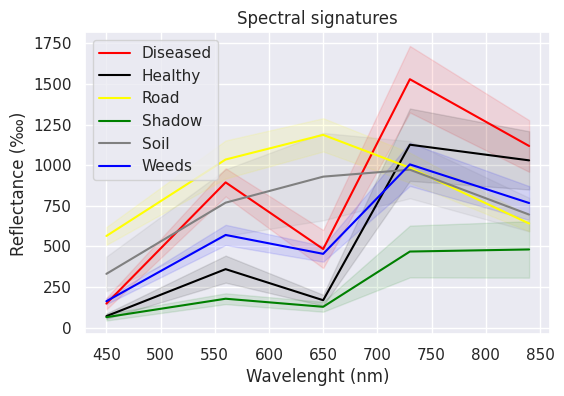

In [ ]:
plt.rcParams['figure.dpi'] = 100
SpectralSignature(df_ph, idxInicioBandas,nomeVarResposta, nomesClasses,coresClasses,'Spectral signatures')

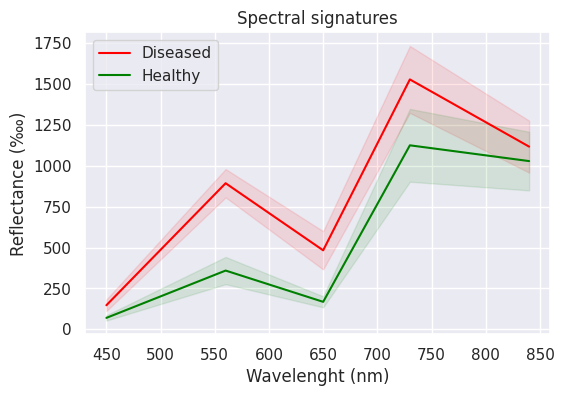

In [ ]:
plt.rcParams['figure.dpi'] = 100
SpectralSignature(df_ph, idxInicioBandas,nomeVarResposta, ['Diseased','Healthy'],['red','green'],'Spectral signatures')


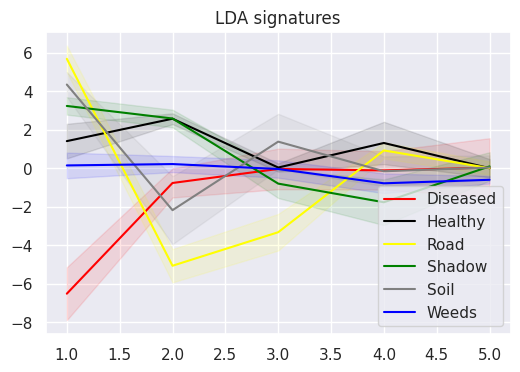

In [ ]:
plt.rcParams['figure.dpi'] = 100
df_lda=convertXtoDf(X_lda,df_ph)
SpectralSignature(df_lda, idxInicioBandas,nomeVarResposta, nomesClasses,coresClasses,'LDA signatures')

Visualizar amostra no plano discriminante principal

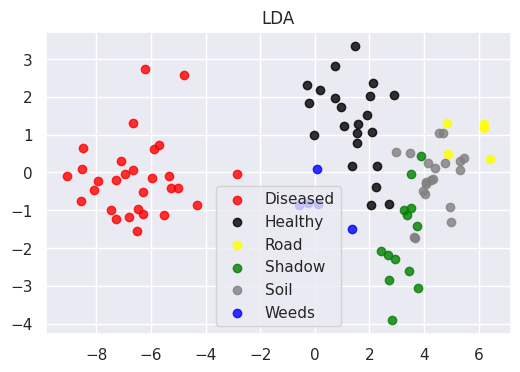

In [ ]:
plt.rcParams['figure.dpi'] = 100
ScatterPlot(X_lda, y, nomesClasses, indicesClasses, coresClasses,0,3)

Aplicar random forest no espaço das funções discrriminantes

In [ ]:
# arg 3 is the depth; arg 4 is bootstrap
y_pred,classifier = classRF(X_lda, y, 3,True, 5)
print(classifier)

RandomForestClassifier(max_depth=3, random_state=0)


Fazer cross validation para testar a qualidade da classificação e construir matriz de erro aparente (100% das observações) 

In [ ]:
#print(X_lda_hyper,y)

scores = CrossVal(classifier, X_lda,y,cv=5)
scores

AUC: 0.93 (+/- 0.11)


array([0.9474, 0.9474, 1.    , 0.8421, 0.8889])

In [ ]:
print(nomesClasses)
print(confusion_matrix(y, y_pred))


['Diseased' 'Healthy' 'Road' 'Shadow' 'Soil' 'Weeds']
[[29  0  0  0  0  0]
 [ 0 21  0  1  0  0]
 [ 0  0  3  0  2  0]
 [ 0  1  0 11  1  0]
 [ 0  1  0  0 19  0]
 [ 0  0  0  0  1  4]]


Aplicar lda, classificar e visualizar o resultado

In [ ]:
data_ph.shape

(5, 410, 410)

In [ ]:
CW={0:1,1:1,2:1,3:1,4:1,5:1}
depthRF=3
bootstrap=True
img_classif=ldaRfClassifyImage(data_ph, df_ph,idxInicioBandas,nomeVarResposta,depthRF,bootstrap,CW)
img_classif.shape
unique, counts = np.unique(img_classif, return_counts=True)
print(unique, counts)


(94, 5)
(94, 5)
[0 1 2 3 4 5] [14458 65637  7821 18065 48379 13740]


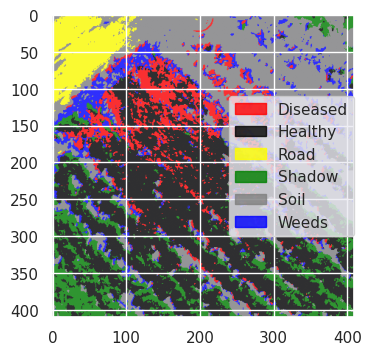

In [ ]:
plt.rcParams['figure.dpi'] = 100
Chart(img_classif, coresClasses,nomesClasses,indicesClasses,0.8)